In [ ]:
# Установка pydicom
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.2 MB/s eta 0:00:00


In [ ]:
# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image

# Для работы с изображениями
from PIL import Image

# Для работы с dcm-изображениями
import pydicom as dicom

# Для работы с nii-изображениями
import nibabel as nib

# Инструменты для работы с массивами
import numpy as np

# Для вычислений
import scipy.ndimage

# Для работы с файлами
import os, shutil
from google.colab import drive

# Увеличение объёма оперативной памяти Colab
import resource
resource.setrlimit(resource.RLIMIT_DATA, (2**30, 2**31-1))

# очистка ОЗУ
import gc

# Игнорирование предупреждений
import warnings

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# Глобальные параметры

IMG_RESOLUTION = 512                                            # Разрешение картинки
DATA_DIR = os.path.join(os.sep, 'content', 'data')              # Папка с данными
CLASS_COUNT = 2                                                 # Количество классов (с выпотом и без) 

# Получаем пути к папкам с оригинальными изображениями и плевральными масками
original_dir = os.path.join(DATA_DIR, 'Original')               # Папка с оригинальными DICOM файлами
effusions_dir = os.path.join(DATA_DIR, 'Effusions')             # Папка с файлами плевральных выпотов
thor_cav_dir = os.path.join(DATA_DIR, 'Thoracic_Cavities')      # Папка с файлами грудных полостей

Скачиваем архивы и распаковываем в папку data.

In [ ]:
# Подключаем Google Drive и прописываем путь к датасетам

gdrive_path = os.path.join(os.sep, 'content', 'drive')
drive.mount(gdrive_path)

drive_data_dir = os.path.join('MyDrive', 'Colab Notebooks', 'УИИ', 'Стажировка',
                              '2. Radlogics', 'data')

Mounted at /content/drive


In [ ]:
# Оригинальные сканы

original_zip = os.path.join(gdrive_path, drive_data_dir, 'Original.zip')
!unzip -qo "$original_zip" -d $DATA_DIR

#!gdown -q https://drive.google.com/uc?id=13Fm6vu45kkU8o85Lp2JVtItItIOJlovc
#!unzip -qo Original -d data

In [ ]:
# Датасет с масками выпотов

#effusions_zip = os.path.join(gdrive_path, drive_data_dir, 'effusions_png.zip')
#!unzip -qo "$effusions_zip" -d $DATA_DIR
!gdown -qO PleThora_Effusions_June_2020.zip https://wiki.cancerimagingarchive.net/download/attachments/68551327/PleThora%20Effusions%20June%202020.zip?version=1&modificationDate=1593202778373&api=v2
!unzip -qo PleThora_Effusions_June_2020 -d data

In [ ]:
# Датасет с масками грудных полостей

!gdown -qO PleThora_Thoracic_Cavities_June_2020.zip https://wiki.cancerimagingarchive.net/download/attachments/68551327/PleThora%20Thoracic_Cavities%20June%202020.zip?version=1&modificationDate=1593202695428&api=v2
!unzip -qo PleThora_Thoracic_Cavities_June_2020 -d data

Напишем функцию для формирования конечной папки с изображениями, будь то:
- LUNG1-XXX;
- LUNG1-XXX/какая-то_папка
- LUNG1-XXX/какая-то_папка1/какая-то_папка2

In [ ]:
# Функция получения пути к папке с изображениями, будь то:
# LUNG1-XXX;
# LUNG1-XXX/какая-то_папка
# LUNG1-XXX/какая-то_папка1/какая-то_папка2

def get_full_path(sub_path):  # sub_path - полный путь к папке LUNG1-XXX
    
    full_path = sub_path
    for _ in range(2):
        if os.path.exists(os.path.isdir(os.path.join(full_path, os.listdir(full_path)[0]))):
            path = os.path.join(full_path, os.listdir(full_path)[0])
        if os.path.isdir(path):
            full_path = path

    return full_path

In [ ]:
# Функция получения списка исключительно папок в определённой директории

def get_folders(path):                        # путь к папке с данными

    # Создаём список, содержащий только папки
    folders = []
    for item in os.listdir(path):             # список элементов в директории
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            folders.append(item)

    return folders

In [ ]:
# Получаем списки папок LUNG1-XXX и переводим их в numpy массив

orig_dir_np = np.array(sorted(get_folders(original_dir))) # папки с оригинальными изображениями
eff_dir_np = np.array(sorted(get_folders(effusions_dir))) # папки с плевральными выпотами

# Отфильтровываем директории в eff_dir_np, которых нет в orig_dir_np
eff_dir_np = eff_dir_np[np.in1d(eff_dir_np, orig_dir_np)]

###Конвертирование nii.gz в png

In [ ]:
# Функция для конвертации 3D файлов nii.gz в 2D png

def nii_to_png_convert():

    list_nii_png_f = []   # список флагов успешной конвертации

    for lung_folder in sorted(eff_dir_np):

        nii_png_f = True  # флаг успешной конвертации для экземпляра

        # Пути к директориям с файлами dcm и nii.gz
        orig_path = get_full_path(os.path.join(original_dir, lung_folder))
        eff_path = os.path.join(effusions_dir, lung_folder)   

        # Берём первый файл (first_reviewer)
        nii_file = os.path.join(eff_path, sorted(os.listdir(eff_path))[0])

        # Директория с конвертированными png
        png_dir = os.path.join('PNG', 'Effusions', lung_folder)
        if not os.path.exists(png_dir): os.makedirs(png_dir)

        # Для каждого среза
        try:
            for img_slice_num in range(len(os.listdir(orig_path))):

                # Получаем маску выпота в 2D numpy
                warnings.filterwarnings('ignore')
                mask_img = nib.load(nii_file).get_data()[:, :, img_slice_num].astype(np.uint8)
                warnings.filterwarnings('default')

                # Конвертируем в png и сохраняем
                nii_to_png = Image.fromarray(mask_img)
                nii_to_png.save(os.path.join(png_dir, f'effusion_{img_slice_num+1:03d}.png'))

                # Читаем сохранённый png в numpy массив для проверки
                png_path = os.path.join(png_dir, f'effusion_{str(img_slice_num+1).zfill(3)}.png')
                png_img = np.array(Image.open(png_path).convert('L'))

                # Сравниваем сохранённый png с оригинальной маской
                if nii_png_f:
                    nii_png_f = np.array_equal(mask_img, png_img)

                # Если маски где-то не совпадают - сообщаем об этом
                if not nii_png_f: print(lung_folder, png_path, nii_png_f,'\n')
                list_nii_png_f.append(nii_png_f)
        except:
            # Если что-то не по плану, сообщаем об этом
            print(lung_folder, 'пропущена')
            os.rmdir(png_dir)

    # Выводим результат
    print('NII.GZ to PNG converted:', all(list_nii_png_f))

In [ ]:
# Функция для записи архива с png-файлами на диск

def zip_and_save_png(file_name):
    
    # Указываем путь к папке, которую нужно заархивировать
    folder_path = os.path.join('/content', 'PNG')

    # Указываем путь и название архива, который нужно создать
    archive_path = os.path.join(gdrive_path, 'MyDrive', file_name)

    # Создаём архив
    shutil.make_archive(archive_path, 'zip', folder_path)
    
    print('Архив создан и помещён на Google Drive:',
          (os.path.exists(archive_path+'.zip') and os.path.isfile(archive_path+'.zip')))

In [ ]:
# Конвертируем nii.gz в PNG
nii_to_png_convert()

NII.GZ to PNG converted: True


In [ ]:
# Архивируем и сохраняем на диск
zip_and_save_png('effusions_png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Архив создан и помещён на Google Drive: True


###Просмотр и анализ

Посмотрим картинки.

In [ ]:
# Функция для отображения трёх картинок из разных наборов

def plot_all_sets(img1, img2, img3,
                  title1 = 'Оригинальное изображение',
                  title2 = 'Плевральный выпот',
                  title3 = 'Грудная полость'):

    plt.figure(1, figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.title(title1, fontweight='bold')
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(title2, fontweight='bold')
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title(title3, fontweight='bold')
    plt.imshow(img3, cmap='gray')
    plt.axis('off')

    plt.show()

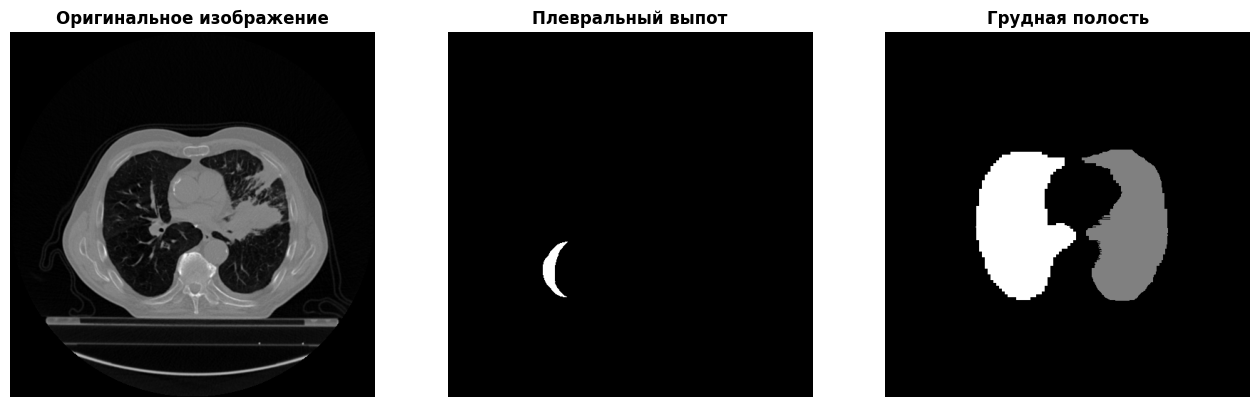

<class 'pydicom.dataset.FileDataset'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)


In [ ]:
img_slice = 64    # номер среза изображения
lung_num = 1      # номер папки с изображениями (параметр XXX в LUNG1-XXX)

# Определяем название папки
lung_folder = f'LUNG1-{str(lung_num).zfill(3)}'

# Оригинальное изображение в формате dcm
img_orig = dicom.dcmread(os.path.join(get_full_path(os.path.join(original_dir, lung_folder)),
                                      f'1-{str(img_slice).zfill(3)}.dcm'))
img_orig_np = img_orig.pixel_array

# Отключаем предупреждения - для метода .get_data()
warnings.filterwarnings('ignore')

# Маска плеврального выпота в формате nii
img_eff = nib.load(os.path.join(effusions_dir, lung_folder,
                                f'{lung_folder}_effusion_first_reviewer.nii.gz'))
img_eff_np = img_eff.get_data()[:, :, img_slice]

# Маска плевральной грудной полости в формате nii
img_thor_cav = nib.load(os.path.join(thor_cav_dir, lung_folder,
                                     f'{lung_folder}_thor_cav_primary_reviewer.nii.gz'))
img_thor_cav_np = img_thor_cav.get_data()[:, :, img_slice]
warnings.filterwarnings('default')
# переворачиваем снимок
img_thor_cav_np = np.rot90(img_thor_cav_np)

# Рисуем
plot_all_sets(img_orig_np, img_eff_np, img_thor_cav_np)

# Выводим информацию о файлах
print(type(img_orig), type(img_orig_np), img_orig_np.dtype, img_orig_np.shape)
print(type(img_eff), type(img_eff_np), img_eff_np.dtype, img_eff_np.shape)
print(type(img_thor_cav), type(img_thor_cav_np), img_thor_cav_np.dtype, img_thor_cav_np.shape)

Посмотрим, что внутри файла dcm.

In [ ]:
print(img_orig)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.32722.99.99.232169797615550376208184444154014090680
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.2

С целью экономии памяти определим минимальное (`min_dcm`) и максимальное (`max_dcm`) значение пикселя в оригинальных картинках dcm для преобразования картинки в numpy-массив соответствующего типа.

Посмотрим толщину среза на каждом изображении и посмотрим, есть ли между ними отличия, а также есть ли отличия по экземплярам.

Кроме того, проверим (`inst_num_f`) соответствие имени файла тегу Instance Number и определим максимальное количество срезов (`max_slices`) для  расширения 3D изображений недостающими срезами.

Также предполагая, что Pleural Effusion лежит в диапазоне от 0 до 400 HU, сформируем маски для этих пределов (`mask_hu`) и сравним с имеющимися масками (`mask_eff`). Для удобства выделим часть кода по этой теме в функции.

In [ ]:
def get_effusions_mask():

    # Получаем срез маски, если удастся
    try:
        effusions_f = True
        nii_file = os.path.join(effusions_dir, lung_folder,                     # путь к маске с выпотом            
                                sorted(os.listdir(os.path.join(effusions_dir,
                                                              lung_folder)))[0])
        warnings.filterwarnings('ignore')
        mask_eff = nib.load(nii_file).get_data()[:, :, img_slice_num]
        warnings.filterwarnings('default')
        if np.sum(mask_eff)==0: effusions_f = False
    except:
        effusions_f = False
        mask_eff = None

    return effusions_f, mask_eff


def plot_slices():
    # Получаем картинку, приведённую к Hounsfield Units   
    image_hu = image_np * img_orig.RescaleSlope + img_orig.RescaleIntercept         

    # Формируем новую маску, предполагая, что выпот находится в пределах от min_eff_hu до max_eff_hu
    # в формате обычных пикселей за пределами маски, 0 - нет выпота, 1 - есть выпот
    mask = (image_hu >= min_eff_hu) & (image_hu <= max_eff_hu)  # создаем булевский массив с условием для маски
    image_hu[mask] = 1 - img_orig.RescaleIntercept              # присваиваем 1 элементам со значениями от min_eff_hu до max_eff_hu
    image_hu[~mask] = - img_orig.RescaleIntercept               # присваиваем 0 элементам, не удовлетворяющим условию
    
    # Переводим маску в формат пикселей изображения dcm
    mask_np = ((image_hu - img_orig.RescaleIntercept) // img_orig.RescaleSlope).astype(np.int8)

    # Рисуем картинки для сравнения
    print(lung_folder)
    plot_all_sets(image_np, mask_np, mask_eff, 'Оригинальное', 'Маска сформированная', 'Маска имеющаяся')


def get_image_params(image, scan, slices_count, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.concatenate(([scan.SliceThickness], np.array(scan.PixelSpacing)), dtype=np.float32)
    
    shape = np.array([slices_count, image.shape[0], image.shape[1]])
    resize_factor = spacing / new_spacing
    new_real_shape = shape * resize_factor
    new_shape = np.array(np.round(new_real_shape), dtype=np.int16)
    real_resize_factor = new_shape / shape
    new_spacing = spacing / real_resize_factor

    return (spacing, real_resize_factor, new_spacing, new_shape)

LUNG1-001


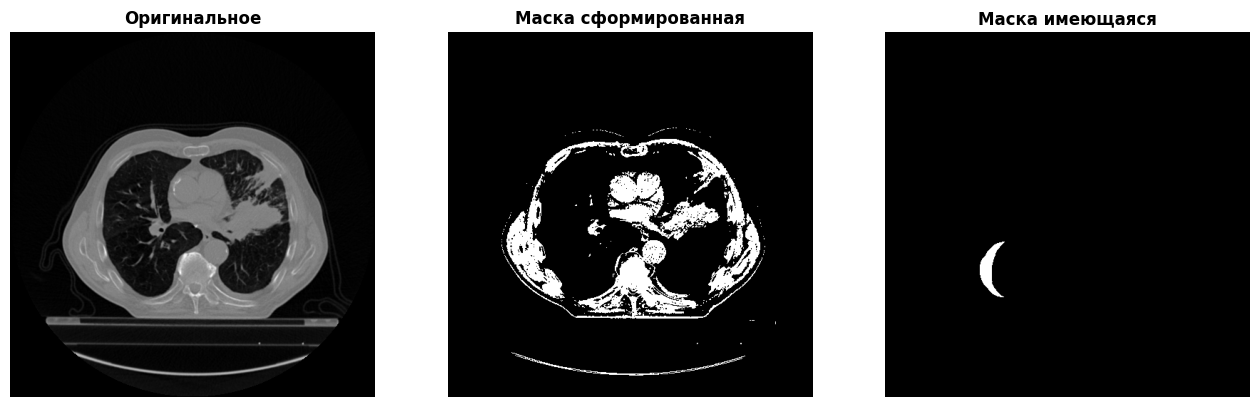

LUNG1-002


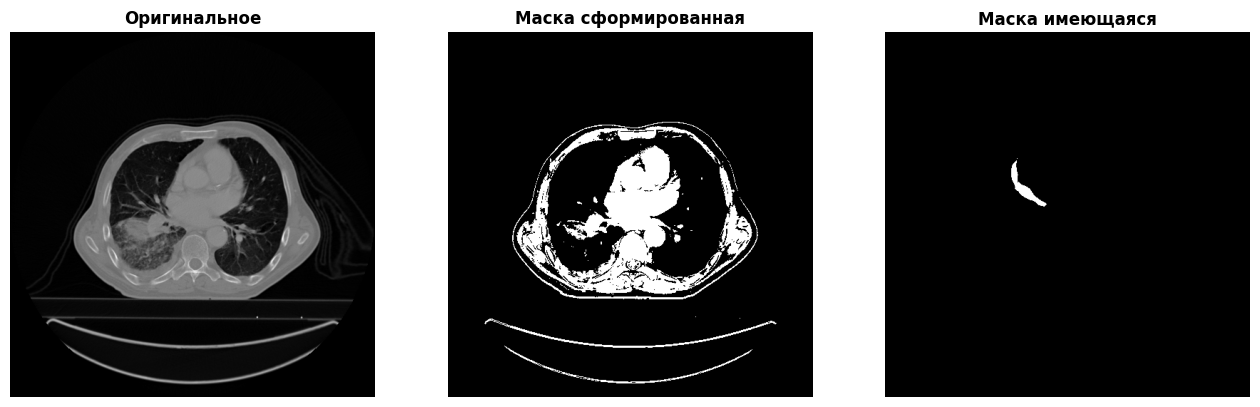

In [ ]:
min_dcm = 4095          # минимальное значение пикселей в изображении
max_dcm = 0             # максимальное значение пикселей в изображении
min_eff_hu = 0          # минимальное значение HU, где может быть выпот
max_eff_hu = 400        # максимально значение HU, где может быть выпот
effusions_count = 0     # количество рисунков с выпотами
max_eff_count = 2       # максимальное количество рисунков
img_slice_num = 64      # номер среза (от балды) для масок с выпотами
files_count = []        # список для количества файлов в папке LUNG1-XXX
slice_thickness = []    # список для толщины среза каждого dcm изображения
pixel_spacing = []      # список расстояний между пикселями каждого dcm изображения
image_params = []       # список расстояний между пикселями, фактор изменения размеров, новые расстояния и новая форма

# Предположим, что имена файлов соответствует тегам Instance Number, для чего включим флаг
inst_num_f = True

# Для всех директорий в каталоге по указанному пути:
for lung_folder in orig_dir_np:

    full_path = get_full_path(os.path.join(original_dir, lung_folder))
    
    # Собираем в лист количество файлов в каждой папке
    files_count.append(len(os.listdir(full_path)))

    # Если есть маска для экземпляра - получаем её (если удаётся вместить в память)
    if effusions_count < max_eff_count:
        effusions_f, mask_eff = get_effusions_mask()
    else: effusions_f = False

    # Проходимся по всем изображениям в папке
    for file_name in sorted(os.listdir(full_path)):

        # Получаем представление снимка в виде датасета и цифры
        img_orig = dicom.dcmread(os.path.join(full_path, file_name))
        image_np = img_orig.pixel_array

        # Собираем массив толщины среза
        slice_thickness.append(img_orig.SliceThickness)
        pixel_spacing.append(img_orig.PixelSpacing)

        # Получаем DICOM параметры для преобразования
        image_params.append(get_image_params(image_np, img_orig, files_count[-1]))

        # Делаем проверку min, max
        min_pv = np.min(image_np)               # минимальное значение пикселей в изображении
        max_pv = np.max(image_np)               # максимальное значение пикселей в изображении 
        if min_dcm > min_pv: min_dcm = min_pv
        if max_dcm < max_pv: max_dcm = max_pv

        # Проверяем соответствие имени файла и тега Instance Number
        if int(img_orig.InstanceNumber) != int(file_name[file_name.index('-')+1:file_name.index('.')]) : inst_num_f = False

        # Если есь маска для оригинального файла, выведено менее 5 срезов, то для среза img_slice_num 
        if effusions_f and (str(img_slice_num) in file_name):
            plot_slices()
            effusions_count += 1

    gc.collect()

# Получаем максимально возможное количество срезов для работы сети без разбалансировки базы
max_slices = max(files_count)
# А также минимальное количество срезов
min_slices = min(files_count)

На сформированных масках видим, что часть данных оригинального изображения отсекается, но полученные маски далеки от имеющихся. Можем использовать предложенный диапазон значений выпотов в единицах HU только для увеличения точности путём отсечения излишних данных. 

In [ ]:
# Смотрим полученные значения
print('min pixel value:', min_dcm)
print('max pixel value:', max_dcm)
print('Instance Number flag:', inst_num_f)
print('Минимальное количество срезов:', min_slices)
print('Максимальное количество срезов:', max_slices)
print('Уникальные значения толщины среза dcm изображений:', np.unique(slice_thickness))
print('Уникальные значения расстояний между пикселями dcm изображений:', np.unique(pixel_spacing))
print('Количество полученных значений толщины среза dcm изображений:', len(slice_thickness))
print('Количество полученных значений расстояние между пикселями среза dcm изображений:', len(pixel_spacing))
print('Количество файлов dcm:', sum(files_count))
pixel_spacing[133:136]

min pixel value: -1024
max pixel value: 4095
Instance Number flag: True
Минимальное количество срезов: 75
Максимальное количество срезов: 297
Уникальные значения толщины среза dcm изображений: [3.]
Уникальные значения расстояний между пикселями dcm изображений: [0.7207     0.812      0.898      0.91210938 0.9765625  0.977     ]
Количество полученных значений толщины среза dcm изображений: 48568
Количество полученных значений расстояние между пикселями среза dcm изображений: 48568
Количество файлов dcm: 48568


[[0.9765625, 0.9765625], [0.9765625, 0.9765625], [0.9770, 0.9770]]

Видим, что значения пикселей лежат в пределах (-1024:4095) - можем использовать тип int16 для формирования данных и float16 для нормирования.

Названия файлов соответствуют тегу Instance Number, а значит будем придерживаться прямой последовательности при формировании массивов данных.

In [ ]:
# Найдём экземпляры, в которых количество срезов > num

num = 150

files_np = np.array(files_count)
file_indexes = np.where(files_np > num)
print(file_indexes)
print(files_np[file_indexes])
print(orig_dir_np[file_indexes])

(array([ 33,  60,  65,  66,  73,  75,  82,  84,  92,  96,  98,  99, 100,
       121, 350]),)
[176 176 176 176 176 176 176 176 297 176 176 216 176 184 173]
['LUNG1-038' 'LUNG1-067' 'LUNG1-073' 'LUNG1-075' 'LUNG1-082' 'LUNG1-086'
 'LUNG1-093' 'LUNG1-096' 'LUNG1-104' 'LUNG1-108' 'LUNG1-110' 'LUNG1-111'
 'LUNG1-112' 'LUNG1-133' 'LUNG1-371']


Далее посмотрим количество срезов в пересчёте с учётом растояния и resize_factor.

In [ ]:
# Смотрим количество срезов в пересчёте с учётом растояния и resize_factor
print(np.unique(np.array(image_params)[:, 3, 0]))

# Обновлённая форма данных для первого и второго экземпляров
print(np.array(image_params)[:, 3][files_count[0]-1:files_count[0]+1])

[225. 246. 252. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291. 297.
 300. 303. 306. 309. 312. 315. 318. 321. 324. 327. 330. 333. 336. 339.
 342. 345. 348. 351. 354. 357. 360. 363. 366. 369. 372. 375. 378. 381.
 387. 390. 393. 396. 399. 402. 405. 408. 417. 426. 429. 432. 519. 528.
 552. 648. 891.]
[[402. 500. 500.]
 [333. 500. 500.]]


Просто берём это во внимание. Возможно, как-то можно будет использовать в дальнейшем для повышения точности сети.

Теперь посмотрим левые верхние пиксели на масках с выпотом и плевральной грудной полостью и сравним их с аналогичными пикселями на масках оригинальных изображений.

In [ ]:
warnings.filterwarnings('ignore')

# маска1 - с плевральной грудной полостью
img_thor_cav = nib.load(os.path.join(thor_cav_dir, 'LUNG1-004', 'LUNG1-004_thor_cav_primary_reviewer.nii.gz'))
img_thor_cav_np = np.rot90(img_thor_cav.get_data()[:,:,0])
print(type(img_thor_cav), type(img_thor_cav_np), img_thor_cav_np.dtype, img_thor_cav_np.shape)

# маска2 - с плевральным выпотом
img_eff = nib.load(os.path.join(effusions_dir, 'LUNG1-005', 'LUNG1-005_effusion_first_reviewer.nii.gz'))
img_eff_np = img_eff.get_data()[:,:,0]
print(type(img_eff), type(img_eff_np), img_eff_np.dtype, img_eff_np.shape)

warnings.filterwarnings('default')

# оригинальное для сравнения с маской1
image_obj = dicom.dcmread(os.path.join(original_dir, 'LUNG1-004', '09-24-2006-StudyID-NA-27873',
                                       '0.000000-NA-20785', '1-001.dcm'))
image_np = image_obj.pixel_array
print(type(image_obj), type(image_np), image_np.dtype, image_np.shape)

# оригинальное для сравнения с маской2
image_obj2 = dicom.dcmread(os.path.join(original_dir, 'LUNG1-005', '01-01-2014-StudyID-NA-93819',
                                        '1.000000-NA-68747/1-01.dcm'))
image_np2 = image_obj.pixel_array
print(type(image_obj), type(image_np), image_np.dtype, image_np.shape)

# Значения пикселей
print(img_thor_cav_np[0, 0], image_np[0, 0])
print(img_eff_np[0, 0], image_np2[0, 0])

<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'nibabel.nifti1.Nifti1Image'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'pydicom.dataset.FileDataset'> <class 'numpy.ndarray'> uint16 (512, 512)
<class 'pydicom.dataset.FileDataset'> <class 'numpy.ndarray'> uint16 (512, 512)
0 0
0 0


Из выполненного кода видим, что везде нули - ими и будем заполнять недостающие срезы dcm.

###Effusions

Найдём номера первого и последнего срезов во всём датасете, где присутствует выпот.

In [ ]:
first_eff_slice_num = 297
last_eff_slice_num = 0

for lung_folder in eff_dir_np:

    full_path = get_full_path(os.path.join(effusions_dir, lung_folder))

    # Проходимся по всем изображениям в папке
    for img_slice_num in range(len(os.listdir(full_path))):

        png_path = os.path.join(full_path, f'effusion_{str(img_slice_num+1).zfill(3)}.png')

        # Наличие значения 1 в пикселях говорит о наличии выпота
        if (np.array(Image.open(png_path).convert('L')) == 1).any():
            if first_eff_slice_num > img_slice_num: first_eff_slice_num = img_slice_num
            if last_eff_slice_num < img_slice_num: last_eff_slice_num = img_slice_num

first_eff_slice_num, last_eff_slice_num

(0, 160)